# 23新卒データベース研修: SQL演習

Google Colaboratory（通称Colab）を利用すると Python のスクリプトを対話的に実行した結果をNotebookという形式でまとめることができます。ここではGoogleのBigQueryというサービスやSQLiteというアプリケーションに組み込み可能なリレーショナルデータベースを利用しSQLクエリなどの使い方を学んでいきます。

```
【注意】新型コロナウイルスに関係するオープンデータを取り扱っています。
新型コロナウイルスについては、必ず1次情報として厚生労働省や首相官邸のウェブサイトなど公的機関で発表されている情報をご確認ください。
```

### 目次

1. 設定
2. データの取得
3. データの操作
4. 集計
1. 条件式
5. 集合操作
6. インデックス
7. 【応用】分析関数（ウィンドウ関数）
1. 片付け

## 設定

#### Notebookのコピー
`ファイル` - `ドライブにコピーを保存` を選択し、Notebookをマイドライブにコピーします。
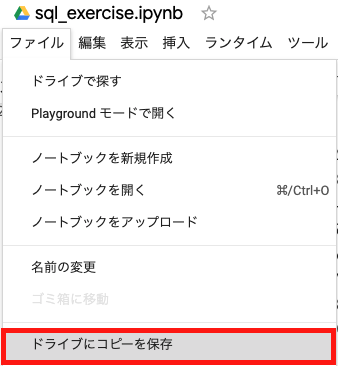

Google Cloud SDK設定

最初にBigQueryを利用するための環境を構築していきます。まずはGoogleアカウントのOAuthトークンを取得しノートブック上でGoogle Cloud SDKを利用できるようにします。

認証の流れ

- 下記のスクリプトを実行する（Shift + Enter）
- 表示されるURLをブラウザで開きColaboratoryによるアクセスを許可
- 英数字と記号からなるトークン文字列をコピー
- URLの下に入力されている入力ボックスにトークン文字列をペーストしてEnter

まずは下記のセルを実行してみましょう。
セルのコードを実行するには、セルをクリックして選択し、コードの左側にある実行ボタンをクリックするか、キーボード ショートカット「command+return」または「Ctrl+Enter」を使用します。



In [ ]:
#
# OAuth認証
#
from google.colab import auth
auth.authenticate_user()

`!`（びっくりマーク）で始まる行はシェルコマンドとして取り扱われます。

gcloud コマンドを使って認証情報が設定できたか確認していきます。

In [ ]:
# このセルの実行結果に自分のメールアドレスが表示されたら準備完了です
! gcloud auth list

Google Cloud SDKの設定を確認できたら安全のためブラウザのトークンが表示されているタブを閉じておきましょう。

### 演習用のGCPプロジェクト作成

GCPに限らずクラウドサービスでは無料枠が提供されていることがあります。クラウドサービスのコスト感を掴むには実際に触ってみるのが手っ取り早いです。基本的にはクラウドサービス側の思惑で料金が決まっているので触ってみると思っているより安かったり高かったりすることがあります。

BigQueryの場合、サンドボックスというオプションが無料枠に相当します。これを利用するための演習用のGCPプロジェクトを作成してみましょう。

ここで作成するGCPプロジェクトのIDは下記のセルを実行することで取得できます。

In [ ]:
import uuid
PROJECT_ID=f'db-training-2023-{str(uuid.uuid4())[:8]}'

PROJECT_ID

下記のセルを実行すると、GCPプロジェクトを作成できます。
波括弧で囲まれた文字列はPythonの式として評価されるため、`{PROJECT_ID}` には上記で取得したプロジェクトIDが入ります。

In [ ]:
! gcloud projects create {PROJECT_ID}

### BigQueryを使ってみる

ここで `%%` で始まる文字列はセルマジックと呼ばれる機能で、セルに対して拡張機能を適用するときに使用します。ここでは BigQuery との連携機能を使用しており `%%bigquery` という文字列の下にあるSQLクエリを BigQuery 上で実行することができます。

In [ ]:
import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.project = PROJECT_ID

上記のセルを実行すると、 `%%bigquery` で使用するGCPプロジェクトとして前節で作成したプロジェクトを指定できます。
なお、本演習では使用していませんが、 `%%bigquery --project {PROJECT_ID}` のように `%%bigquery` の引数として使用するGCPプロジェクトを指定する方法もあります。

In [ ]:
%%bigquery
select 'Hello' as World

上記のSQLを実行し下の画像のような結果が表示されたらBigQueryの設定完了です 👌

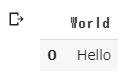

### SQLite設定

BigQueryサンドボックスでは一部実行できないクエリがあるため、そのようなクエリについてはSQLite上で実行します。

In [ ]:
! pip install ipython-sql==0.3.9 SQLAlchemy==1.4.46

上記のセルを実行すると `ipython-sql` という拡張機能をインストールできます。これを使うことで、SQLiteに対してクエリを実行できるようになります。

In [ ]:
# ipython-sqlの読み込み
%load_ext sql

# SQLiteへの接続
%sql sqlite:///tmp.sqlite3

上記のセルを実行すると、 `ipython-sql` の読み込みとSQLiteへの接続ができます。

### SQLiteを使ってみる

`%%sql` マジックを使うとSQLiteに対してクエリを実行できます。

In [ ]:
%%sql
select 'Hello' as World

上記のSQLを実行し下のような結果が表示されたらSQLiteの設定完了です 👌

```
World
Hello
```

### Colab TIPS: ツールバーにコーギーや猫を表示するには 🐶🐱

[ツール] => [設定] => [その他] で [コーギーモード] ( [猫モード] ) を有効化すると、ツールバー上でコーギー (猫) が走ります。

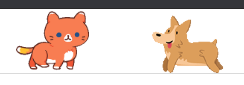

## データの操作

SQLiteを使ってテーブルにレコードを追加・更新・削除する方法について確認していきます。

BigQueryのサンドボックス環境では、書き込み操作ができないため、SQLiteで代用しています。

### テーブルの作成

SQLiteではCREATE TABLE文を実行することでテーブルを作成することができます。

```sql
    CREATE TABLE <テーブル名> (
      -- カラム情報
      <カラム名> <データ型>,
      ...
    )
```

問1: BIGINT型の列`id`と、STRING型の列`message`を持つテーブル、`messages`を作ってみましょう。

In [ ]:
%%sql


In [ ]:
#@title 解答 {display-mode: "form"}
%%sql
create table messages (
    id bigint,
    message string
)


上記のクエリを実行すると以下のエラーが出ることがありますが、無視して問題ありません。
気になる場合はクエリの末尾に `;select "DONE" as message` のようなクエリを追加すると良いです。

```
ResourceClosedError: This result object does not return rows. It has been closed automatically.
```

下のSQLでmessageテーブルの中身が確認できます。まだ何も入っていません。

In [ ]:
%%sql
select
  *
from
  messages


### レコードの追加

テーブルを作成できたらテーブルにレコードを入れてみましょう。INSERT文を利用するとテーブルにデータを格納することができます。

```sql
    INSERT INTO
        <テーブル名>
    VALUES
        (v1, v2, ...),
        ...
```

問2: messagesテーブルにレコードを追加してみましょう。
`id`は`1`、`messages`は何でも構いません。複数レコード追加してもいいでしょう。

In [ ]:
%%sql


In [ ]:
#@title 解答 {display-mode: "form"}
%%sql
insert into
  messages
values
  (1, 'こんにちは'),
  (2, '夜だけどこんにちは')


下のクエリを実行すると、messagesテーブルの内容を確認できます。

In [ ]:
%%sql
select
  *
from
  messages


### レコードの更新

続けて、UPDATE文を利用することで検索条件にマッチするレコードを更新することができます。

```sql
    UPDATE
        <テーブル名>
    SET
        <カラム> = <値>,
        ...
    WHERE
        <検索条件>
```

問3: messagesテーブルのidが1のレコードのmessageを「こんにちはこんにちは」に変更しましょう。

In [ ]:
%%sql


In [ ]:
#@title 解答 {display-mode: "form"}
%%sql
-- idが1のレコードのメッセージを更新する
update
  messages
set
  message = 'こんにちはこんにちは'
where
  id = 1

下のクエリを実行すると、messagesテーブルの内容を確認できます。

In [ ]:
%%sql
select
  *
from
  messages
limit 10

### レコードの削除

主にコストの面でストレージには限りがある場合があるので不要なレコードは削除しましょう。DELETE文を利用すると検索条件にマッチするレコードを削除することができます。

```sql
    DELETE FROM
        <テーブル名>
    WHERE
        <検索条件>
```

問4: messagesテーブルからidが1のレコードを削除しましょう。

In [ ]:
%%sql


In [ ]:
#@title 解答 {display-mode: "form"}
%%sql
delete from
  messages
where
  id = 1

下のクエリを実行すると、messagesテーブルの内容を確認できます。 idが1のレコードが消えているか確認しましょう。

In [ ]:
%%sql
select
  *
from
  messages
limit 10

検索条件を指定しない場合は全てのレコードが削除されます。

In [ ]:
%%sql
delete from messages

In [ ]:
%%sql
select
  *
from
  messages
limit 10

MySQLなどのRDBMSにはTRUNCATE文という全レコードを削除するためのコマンドが用意されています。

それぞれ以下のような特徴があります:

- DELETE文
    - トランザクションを使っている場合はロールバックできる
- TRUNCATE文
    - テーブルを作り直す
    - DELETE文より高速に動作し、AUTO INCREMENTを初期化できる
    - RDBMSによってはロールバックできない


### テーブルの削除

DROP TABLE文を利用することでテーブルを削除することができます。

問5: messagesテーブルを削除しましょう。

In [ ]:
%%sql


In [ ]:
#@title 解答 {display-mode: "form"}
%%sql
drop table messages;

In [ ]:
%%sql
select
  *
from
  messages
limit 10

テーブルが存在しない旨のエラーメッセージ ( `no such table: messages` ) が出ることが確認できます。

## データの取得

BigQueryでは公開データセットが提供されています。まずは公開データセットにどのようなデータが入っているかの調査を通してSELECT文の使い方を学んでみましょう。

BigQueryではINFORMATION_SCHEMAというテーブル情報を取得するためのメタデータが提供されているので、こちらのメタデータを使ってデータセットの調査を行なっていきます。
なお、同様のメタデータはMySQLやPostgreSQL等のRDBMSでも提供されています。

こちらではジョンズ・ホプキンス大学が提供する新型コロナウイルス（COVID-19）に関する公開データセットのテーブル情報を参照しています。


### SELECT文: 基本形

SQLクエリを使ってデータを取得する時はSELECT文を利用します。

```sql
    SELECT
        <式>
    FROM
        <テーブル名>
```

下記のクエリでは、先ほど紹介したジョンズ・ホプキンス大学が提供する新型コロナウイルス（COVID-19）に関する公開データセットのテーブル情報を取得しています。

- Project ID: `bigquery-public-data`
- Dataset Name: `covid19_jhu_csse`
- Schema Name: `INFORMATION_SCHEMA`
- テーブル名: `TABLES`

In [ ]:
%%bigquery
-- これはコメントです
select
  -- 全てのカラムを取ってくる
  *
from
  bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES

公開データセットに含まれるテーブルの名称や作成時刻が確認できました。

### LIMIT句

LIMIT句を利用することで取得するレコード数を制限することができます。
大量のデータを制限なしに取得すると、データベースのクライアントに負荷がかかりトラブルの原因になります。そのため、SELECT文を使ってデータを見るときはLIMIT句で取得するレコード数を制限する習慣を付けると良いでしょう。

問1. LIMIT句を使って confirmed_cases というテーブルに含まれるレコードを10件表示してみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
limit 10

### ORDER BY句
取得するレコードの順番を並び替える際はORDER BY句を使います。

ORDER BY で指定したカラム名の後に `ASC` を付与すると昇順、 `DESC` を付与すると降順でソートされます。
何もつけなかった場合は昇順になります。

問2. confirmed_casesを、country_or_region列で昇順・降順で並び替えて10件表示してみましょう。

In [ ]:
%%bigquery



In [ ]:
%%bigquery



In [ ]:
#@title 解答(昇順) {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region
limit 10

In [ ]:
#@title 解答(昇順) {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region asc
limit 10

In [ ]:
#@title 解答(降順) {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region desc
limit 10

### WHERE句

WHERE句に検索条件を指定すると取得対象のレコードを絞り込むことができます。

先ほどのクエリの結果をみると `country_or_region` というカラムに国名が入っていることがわかります。

問3. WHERE句を使って日本（`Japan`）のレコードを取得してみましょう。



In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_or_region = 'Japan'
limit 10

日本の感染者数に関するデータが取得できました。国名を表すカラムのほかに位置情報に関する情報も入っており、`_1_22_20` などのカラムは `_MM_DD_YY` 形式である日付における感染者数を表しているようです。

## 集計

### COUNT関数

`tmp` スキーマを作成します。BigQueryではCREATE SCHEMA文を使うとスキーマ (データセット) を作成できます。

In [ ]:
%%bigquery
create schema tmp;

BigQueryの公開データセットからデータを取得し `tmp` スキーマの `confirmed_cases` というテーブルにデータを格納します。

多くのクエリエンジンにはテーブルを作成する際に SELECT 文の実行結果をそのまま利用できる `CREATE TABLE AS`（CTAS） と呼ばれる構文が用意されています。

データを整形する過程で必要な一時データを格納したいときや、異なるデータベースサーバーに入っているテーブルデータをコピーするときなどに便利な機能です。

In [ ]:
%%bigquery
create table tmp.confirmed_cases as
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

COUNT関数を利用するとレコード数を数えることができます。

問1. 先ほど作成したテーブルにデータが欠損なく入っているかを確認するため、公開データセットと先ほど作成したテーブルのレコード数を比較してみましょう。

In [ ]:
%%bigquery


In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  count(1) as num
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  count(1) as num
from
  tmp.confirmed_cases

公開データセットのレコード数と先ほど作成したテーブルのレコード数が一致していれば、欠損はなさそうです。

### 集約操作（GROUP BY句）

データセットを見ていると国によっては複数のレコードを持っていることが分かります。GROUP BY 句を利用すると指定したカラムの値でグループ分けした結果に対して COUNT 関数などを利用した集計を行うことができます。

```sql
    SELECT
      <カラム>
    FROM
      <テーブル>
    WHERE
      <条件>

    -- NEW!!
    GROUP BY
      <集約するカラム> -- 複数指定可能
    HAVING
      <集約後の結果に対する条件>
```

#### BigQuery => Pandas

公開データセットでは各レコードに国・州ごとの感染者数が入っています。

|||日付1|日付2|...|
|:--:|:--:|--:|--:|--:|
|国A|州1|123|456|...|
|国A|州2|234|567|...|
|国B||789|999|...|

しかし、日ごとの推移を見る場合、各レコードに国・州・日付ごとの感染者数が入っている形式の方が扱いやすいです。

||||感染者数|
|:--:|:--:|:--:|--:|
|国A|州1|日付1|123|
|国A|州1|日付2|456|
|国A|州1|...|...|
|国A|州2|日付1|234|
|国A|州2|日付2|567|
|国A|州2|...|...|
|国B||日付1|789|
|国B||日付2|999|
|国B||...|...|

こちらの操作をSQLで行うことは可能ですが、プログラミング言語で行った方が簡単にできます。ここでは Pandas という Python のデータ操作用フレームワークを利用して行ってみましょう。

"pandas - Python Data Analysis Library"
https://pandas.pydata.org/

複数の州を持つ国の confirmed_cases の和を国・日別に取ってみましょう。

`%%bigquery` マジックでは引数に変数名を指定すると、クエリの実行結果を Pandas の DataFrame として格納してくれます。
また、BigQueryでは`except`を使うことで、指定したカラム以外の全カラムを取得することができます。

In [ ]:
%%bigquery df_provinces
select
  -- 地理データ以外の全カラムを取得
  * except (latitude, longitude, location_geom)
from
  tmp.confirmed_cases
where
  province_or_state is not null

headメソッドを使って上位のレコードを表示してみます。

In [ ]:
df_provinces.head()

Pandasを使って国・州・日付ごとに感染者数が入っているテーブルを作成します。

"pandasでstack, unstack, pivotを使ってデータを整形 | note.nkmk.me"
https://note.nkmk.me/python-pandas-stack-unstack-pivot/

In [ ]:
import pandas as pd
import datetime

df_pivot_stack = pd.pivot_table(df_provinces, index=['country_or_region', 'province_or_state']).stack().reset_index()
df_pivot_stack.columns = ['country_or_region', 'province_or_state', 'date', 'confirmed_cases']
df_pivot_stack.date = df_pivot_stack.date.map(lambda d: datetime.datetime.strptime(d, '_%m_%d_%y'))
df_pivot_stack

#### Pandas => BigQuery
Pandas DataFrameの `to_gbq` メソッドを使うことでデータフレームをBigQueryのテーブルに格納することができます。

In [ ]:
df_pivot_stack.to_gbq('tmp.pivot_stack', PROJECT_ID, if_exists='replace')

複数州を持つ国についても日別の推移を縦持ちで取れるようになりました。

In [ ]:
%%bigquery
select
  *
from
  tmp.pivot_stack
limit 10

問2. GROUP BY 句を使って国・日別で`confirmed_cases`の合計を集計してみましょう。

ヒント:
*   tmp.pivot_stack テーブルを使います。
*   和の集計には SUM 関数を使います。


In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  country_or_region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  country_or_region,
  date

order by
  country_or_region,
  date

limit 10

## 条件式

### CASE式
CASE式は条件分岐に相当するもので、2通りの書き方があります。

```sql
-- 単純CASE式
CASE <カラム>
    WHEN <値> THEN <カラム = 値のときの返り値>
    ELSE <上記を満たさないときの返り値>
END
```

```sql
-- 検索CASE式
CASE
    WHEN <条件> THEN <条件を満たすときの返り値>
    ELSE <上記を満たさないときの返り値>
END
```


前章では複数の州を持つ国のconfirmed_casesの推移を国・日別で見ましたが、これを大州別・日別で見てみましょう。

国と大州の対応関係は次のようになっています。

|国|大州|
|:--:|:--:|
|Canada|America|
|United Kingdom|Europe|
|France|Europe|
|Netherlands|Europe|
|Denmark|Europe|
|China|Asia|
|Australia|Australia|

問1. 上記の国と大州の表を参考に国名を大州名に変換し、大州・日別のconfirmed_casesの合計を集計してみましょう。

結果のイメージ

|日付|大州|confirmed_cases|
|---|---|---|
|2021-01-01|America|1234|
|2021-01-01|Europe|2345|
|2021-01-01|Asia|3456|
|2021-01-01|Australia|4567|
|2022-01-02|America|1000|


ヒント:
  CASE文を用いて、国名を大州名に変換するとよい

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  case country_or_region
    when 'Canada' then 'America'
    when 'United Kingdom' then 'Europe'
    when 'France' then 'Europe'
    when 'Netherlands'then 'Europe'
    when 'Denmark' then 'Europe'
    when 'China' then 'Asia'
    else country_or_region
  end as region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  region,
  date

order by
  date,
  region

limit 20

上記のクエリは以下のように書くこともできます。

In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  case
    when country_or_region = 'Canada' then 'America'
    when country_or_region IN ('United Kingdom', 'France', 'Netherlands', 'Denmark') then 'Europe'
    when country_or_region = 'China' then 'Asia'
    else country_or_region
  end as region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  region,
  date

order by
  date,
  region

limit 20

## 集合操作(サブクエリ・UNION)

ここから少し複雑なSELECT文を扱っていきます。

### サブクエリ

SELECTの結果を別のクエリ内で使用することをサブクエリと言います。


問1. 全世界のconfirmed_casesのうち、カナダのconfirmed_casesの割合を日別に集計することを考えます。

 (1) 日毎の全世界のconfirmed_casesとカナダのconfirmed_casesの合計をそれぞれ集計してみましょう。


 出力例

 |date|カナダの件数|全世界の件数|
 |---|---|---|
 |2020-09-01| 300| 10000|
 |2020-09-02| 250| 12000|



In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery

select
  date,

  -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
  sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

  sum(confirmed_cases) as confirmed_cases_sum_all
from
  tmp.pivot_stack
group by
  date


limit 10

(2) (1)のクエリをサブクエリとして、全世界のconfirmed_casesのうち、カナダのconfirmed_casesの割合を日別に集計してみましょう。

In [ ]:
%%bigquery



In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  date,
  confirmed_cases_sum_canada,
  confirmed_cases_sum_all,
  1.0 *  confirmed_cases_sum_canada / confirmed_cases_sum_all as confirmed_cases_percent_canada
from
(
  select
    date,

    -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
    sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

    sum(confirmed_cases) as confirmed_cases_sum_all
  from
    tmp.pivot_stack
  group by
    date
)

order by
  date

limit 10

### WITH句
WITH句を使うとサブクエリに名前を付けてクエリの外側に持っていくことができます。これにより、ネストを下げたりサブクエリを再利用したりすることができます。WITH句で定義したサブクエリは通常のテーブルと同様にクエリすることができます。

RDBMSの世界ですとMySQLは長らくサポートしていませんでしたがバージョン8.0から利用できるようになっています。

問2. 問1(2) をWITH句を用いて書き直してみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
with canada_confirmed_cases as (
  select
    date,

    -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
    sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

    sum(confirmed_cases) as confirmed_cases_sum_all
  from
    tmp.pivot_stack
  group by
    date
)

select
  date,
  confirmed_cases_sum_canada,
  confirmed_cases_sum_all,
  1.0 *  confirmed_cases_sum_canada / confirmed_cases_sum_all as confirmed_cases_percent_canada
from canada_confirmed_cases

order by
  date

limit 10

### UNION句

UNION 句を利用するとクエリの結果を縦方向に結合することができます。

公開データセットのテーブル情報を見ると、 onfirmed_cases / recovered_cases / deaths の3テーブルがあることがわかります。

In [ ]:
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES
limit 10

ここでは日本のデータについて confirmed_cases / recovered_cases / deaths の結果を UNION 句で結合してみましょう。

label というカラムに元テーブルの名前を格納することで、どのテーブル由来のデータかを区別できるようにしています。UNION だけだとそれぞれのセットで重複するものが排除されますがその分パフォーマンスが落ちてしまいます。UNION ALL と指定すると重複チェックを行わずに結果を結合することができます。

In [ ]:
%%bigquery
select
  'confirmed' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_or_region = 'Japan'

union all
select
  'recovered' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.recovered_cases
where
  country_or_region = 'Japan'

union all
select
  'death' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.deaths
where
  country_or_region = 'Japan'

# 集合操作(JOIN)

### JOIN

JOINを利用することで複数のテーブルまたはサブクエリを特定の条件で横方向に結合することができます。

```sql
    SELECT
      <式>
    FROM
      <テーブル>

    -- NEW!!
    JOIN
      <結合するテーブル>
    ON
      <結合条件>
```

結合方式には以下の3種類があり、それぞれ役割が異なります。

- 内部結合（INNER JOIN）
  - 一致するもの
- 外部結合（OUTER JOIN）
  - 一致しないときはNULL
- クロス結合（CROSS JOIN）
  - 直積
  - 配列データをバラしたりするときに便利


ここでは SQLite を使って JOIN の使い方を学んでみます。

#### 内部結合 (INNER JOIN)
ゲームを想定したデータでJOINを行ってみましょう。
まず、ユーザー情報とステージ情報、プレイログ (誰がどのステージをプレイしたか) の3テーブルを作ります。

In [ ]:
%%sql
-- ユーザー情報
create table users (
    id bigint,
    user_name string
);

-- ステージ情報
create table stages (
    id bigint,
    stage_name string
);

-- プレイログ (誰がどのステージをプレイしたか)
create table plays (
    id bigint,
    user_id bigint,
    stage_id bigint
)

レコードを追加します。

In [ ]:
%%sql
insert into
  users
values
  (1, 'Alice'),
  (2, 'Bob'),
  (3, 'Charlie')
;

insert into
  stages
values
  (1, 'Easy Stage'),
  (2, 'Normal Stage')
;

In [ ]:
%%sql
insert into
  plays
values
  (1, 1, 1),
  (2, 1, 2),
  (3, 2, 1),
  (4, 1, 1)
;

プレイログを見てみます。

In [ ]:
%%sql
select
  *
from
  plays as p
limit 10

そのままだと誰がどのステージをプレイしたのか分からないのでユーザー情報とステージ情報をJOINしてみます。

In [ ]:
%%sql
select
  p.id,
  u.user_name,
  s.stage_name
from
  plays as p

join
  users as u
on p.user_id = u.id

join
  stages as s
on p.stage_id = s.id
limit 10

人間にわかりやすい形でプレイログが出てきました。

#### 外部結合 (OUTER JOIN)

usersにplaysをLEFT OUTER JOINすると、プレイしていないユーザーもplays由来のカラムがNULLになった状態で出てきます。

In [ ]:
%%sql
select
  *
from
  users as u

left outer join
  plays as p
on p.user_id = u.id
limit 10

`LEFT OUTER JOIN` の考え方ですが、 `LEFT OUTER JOIN` の左にあるテーブル ( `users` ) をベースに右にあるテーブル ( `plays` ) を結合するイメージです。

```sql
users as u left outer join plays as p
```

なお、実際にはほとんど使われませんが、 `RIGHT OUTER JOIN` (右にあるテーブルをベースに左にあるテーブルを結合する) もあるので、知識として知っておくと良いです。

#### クロス結合 (CROSS JOIN)

CROSS JOINは配列データをバラすときに便利です。と言っても具体例をみないと分かりづらいのでSQLiteのJSON型を使ってCROSS JOINの使いどころを確認してみましょう。

In [ ]:
%%sql
-- JSON型を持ったテーブルを作成
create table user_list (
    id bigint,
    users json
)

JSON型のカラムには文字列としてINSERTすることができます

In [ ]:
%%sql
insert into
  user_list
values
  (3, '[1, 2]')

In [ ]:
%%sql
select
  *
from
  user_list
limit 10

配列を1行ずつバラしていくときにCROSS JOINが活用できます。

In [ ]:
%%sql
SELECT
    t.id,
    u.value AS user
FROM user_list AS t
CROSS JOIN
    JSON_EACH(t.users) AS u

## インデックス

RDBMSではデータを高速に取得するためにインデックスと呼ばれる機能が提供されています。

### 準備

100万件のランダムな文字列 UUID を取得します

In [ ]:
%%bigquery df_seq1
select
  x,
  generate_uuid() as uuid1
from
  unnest(generate_array(1, 1000000)) as x
order by
  rand()

In [ ]:
df_seq1.head()

取得したUUIDをSQLiteに格納していきます
インデックスを設定するテーブルには接尾辞 `_ind` がついています

In [ ]:
import sqlite3
df_seq1.to_sql('seq1', sqlite3.connect('tmp.sqlite3'), if_exists='replace')
df_seq1.to_sql('seq1_ind', sqlite3.connect('tmp.sqlite3'), if_exists='replace')

SQLiteではCREATE INDEX文を利用することでインデックスを設定することができます。

`seq1_ind` のカラム `x` に対してインデックスを設定します。

In [ ]:
%%sql
create index seq1_x on seq1_ind(x);

実行時間のプログレスバーを表示するために tqdm をインストールします。

In [ ]:
! pip install tqdm

### 複数のクエリ

インデックスが効果を発揮するのはクエリが複数回実行されるケースになります。ここでは複数回クエリが実行された時のインデックスの効果を体感してみましょう。

以下のスクリプトは `seq1` テーブルからカラム `x` が指定の値になっているレコードを抽出するクエリを100回呼び出したものです。

`%%time` マジックを利用するとセルの実行に掛かる時間を計測することができます。

まずはインデックス未使用の場合で実行してみましょう。

In [ ]:
%%time
import pandas as pd
import sqlite3
import tqdm.notebook as tqdm

def generate_sql(x):
  return f'''
    select
      uuid1
    from
      seq1
    where
      x = {x}
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(100)):
    pd.read_sql(generate_sql(x), con=con)

'done'

続けてインデックスを使用した場合を試してみます。

In [ ]:
%%time
import pandas as pd
import sqlite3
import tqdm.notebook as tqdm

def generate_sql(x):
  return f'''
    select
      uuid1
    from
      seq1_ind -- index x
    where
      x = {x}
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(100)):
    pd.read_sql(generate_sql(x), con=con)

'done'

一瞬で終わりました

### INSERT
インデックスを付与したことによるINSERTへの影響について見ていきましょう。

インデックスを付与していない状態で100万件のデータをINSERTしてみます。

In [ ]:
%%time
import pandas as pd
import sqlite3
import tqdm.notebook as tqdm

def generate_sql(x):
  x+=1000000
  return f'''
    insert into seq1
    values
        ({x},{x},"a")
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(1000000)):
    con.execute(generate_sql(x))

'done'

続いて、インデックスを付与した状態でINSERTしてみます。

In [ ]:
%%time
import pandas as pd
import sqlite3
import tqdm.notebook as tqdm

def generate_sql(x):
  x+=1000000
  return f'''
    insert into seq1_ind
    values
        ({x},{x},"a")
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(1000000)):
    con.execute(generate_sql(x))

'done'

このようにインデックスを付与しているとINSERTが遅くなります。インデックスを付与する場合はその辺りも考慮する必要があります。

## 【応用】分析関数（ウィンドウ関数）

次はBigQueryの世界に戻ってきます。分析関数はデータの集計だけではなく機械学習用のデータセットを作成するのにも便利に使える機能です。分析関数を利用すると、今見ているレコードだけでなく、他のレコードの状態も見て集計処理を実行できます。

RDBMSの世界ですと、MySQLではWITH句と同様にバージョン8.0からサポートされています。

### LAG / LEAD 関数

あるレコードについて指定の順序で前後にあるレコードのカラムを取得するための機能です。
LAG関数で前にあるレコードのカラムを、LEAD関数で後ろにあるレコードのカラムを取得できます。
例えば、日別のログイン履歴からログインした日付と前回ログインした日付の差、すなわちログインしなかった日数を集計するといったことができます。

LAG関数を使って、カナダのブリティッシュコロンビア州における前日のconfirmed_casesを取得してみます。ウィンドウ関数の利用時には `GROUP BY` による集約は必要なく、関数の後ろに `OVER` で始まる順序などの条件指定が入ります。今回の場合ですと、confirmed_casesをdateでソートして、1レコード前のconfirmed_casesを取得しています。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}


%%bigquery
-- カナダのconfirmed_cases推移（日別）
select
  date,
  confirmed_cases,
  lag(confirmed_cases) over (order by date) prev_confirmed_cases
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and province_or_state = 'British Columbia'

order by
  date

元のデータセットはconfirmed_casesが累計値になっています。前日との差分を取ることで1日あたりどれくらい増加したのか集計してみます。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}

%%bigquery
select
  date,
  confirmed_cases,
  confirmed_cases - prev_confirmed_cases as confirmed_cases_diff
from
  (select
    date,
    confirmed_cases,
    lag(confirmed_cases) over (order by date) prev_confirmed_cases
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and province_or_state = 'British Columbia'
  )

order by
  date

### 累積和

先ほどは累計値を日別に変換しましたが、逆に累計値を求めるにはどうすればよいでしょうか。SUM関数やCOUNT関数などもウィンドウ関数として利用することができ、あるレコードまでの累積和などを求めることができます。

In [ ]:
#@title 解答 {display-mode: "form"}

%%bigquery
with
  df_canada as
  (select
    date,
    confirmed_cases as confirmed_cases_original,
    confirmed_cases - prev_confirmed_cases as confirmed_cases_diff
  from
    (select
      date,
      confirmed_cases,
      lag(confirmed_cases) over (order by date) prev_confirmed_cases
    from
      tmp.pivot_stack
    where
      country_or_region = 'Canada'
      and province_or_state = 'British Columbia'
    )
  )

select
  date,
  confirmed_cases_original,
  sum(confirmed_cases_diff) over (order by date) as confirmed_cases_cumsum
from
  df_canada

order by
  date

### RANK / ROW_NUMBER 関数

RANK / ROW_NUMBER 関数を使うとランキングを求めたり行番号を求めることができます。

同一の値に対し、 RANK では同じ番号が振られ、ROW_NUMBERでは最初に見つかった順に番号が振られます。

ROW_NUMBERの結果が1になるレコードだけを取ってくれば、レコードの重複を排除できるため、ROW_NUMBERはレコードの重複排除でよく利用されます。

ここではRANKを利用してconfirmed_casesが多い順にランク付けをしてみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}

%%bigquery
select
  province_or_state,
  confirmed_cases,
  rank() over (order by confirmed_cases desc) as rank
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and date = '2020-03-31'

order by
  confirmed_cases desc

上位三件に絞り込んでみます。

In [ ]:
#@title 解答 {display-mode: "form"}


%%bigquery
select
  *
from
  (select
    province_or_state,
    confirmed_cases,
    rank() over (order by confirmed_cases desc) as rank
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and date = '2020-03-31'
  )
where
  rank <= 3

order by
  rank

## 片付け
演習が終わったら片付けをしましょう。
再び演習を行いたい場合は `設定` を行って新たなGCPプロジェクトを作成してください。

### GCPプロジェクトの削除

In [ ]:
! echo PROJECT_ID: {PROJECT_ID}
! gcloud projects delete {PROJECT_ID}